In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
import gc
from scipy import sparse
%matplotlib inline

# Test switch

In [2]:
# if you want to retrain the models, set train_mode = True
# train_mode = True
train_mode = False

In [3]:
df_train = pd.read_csv('data/sales_train.csv.gz', compression='gzip')
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
# df_date = df_train[['date', 'date_block_num']]
# df_date.drop_duplicates('date_block_num', inplace=True)
# df_date['date_formatted'] = pd.to_datetime(df_date.date, format="%d.%m.%Y")
# df_date[['day','month','year']] = df_date.date.str.split('.',expand=True)
# df_date['date_month'] = (df_date.year + df_date.month).astype(str)
# df_date = df_date[['date_block_num','date_month', 'month','year']]
# df_date

In [5]:
df_test = pd.read_csv('data/test.csv.gz', compression='gzip')
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [6]:
df_item_bigcat = pd.read_csv('data/item_categories.csv')
l = list(df_item_bigcat.item_category_name)
l_cat = l
for ind in range(1,8): l_cat[ind] = 'Access'
for ind in range(10,18): l_cat[ind] = 'Consoles'
for ind in range(18,25): l_cat[ind] = 'Consoles Games'
for ind in range(26,28): l_cat[ind] = 'phone games'
for ind in range(28,32): l_cat[ind] = 'CD games'
for ind in range(32,37): l_cat[ind] = 'Card'
for ind in range(37,43): l_cat[ind] = 'Movie'
for ind in range(43,55): l_cat[ind] = 'Books'
for ind in range(55,61): l_cat[ind] = 'Music'
for ind in range(61,73): l_cat[ind] = 'Gifts'
for ind in range(73,79): l_cat[ind] = 'Soft'
df_item_bigcat['bigcat'] = l_cat
df_item_bigcat

,item_category_name,item_category_id,bigcat
0,PC - Гарнитуры/Наушники,0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2,1,Access
2,Аксессуары - PS3,2,Access
3,Аксессуары - PS4,3,Access
4,Аксессуары - PSP,4,Access
5,Аксессуары - PSVita,5,Access
6,Аксессуары - XBOX 360,6,Access
7,Аксессуары - XBOX ONE,7,Access
8,Билеты (Цифра),8,Билеты (Цифра)
9,Доставка товара,9,Доставка товара


In [7]:
df_items = pd.read_csv('data/items.csv')
df_items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
df_item_bigcat = df_item_bigcat.merge(df_items)
df_item_bigcat.drop(['item_category_name', 'item_name'], axis=1, inplace=True)
df_item_bigcat.head()

,item_category_id,bigcat,item_id
0,0,PC - Гарнитуры/Наушники,5441
1,0,PC - Гарнитуры/Наушники,16255
2,0,PC - Гарнитуры/Наушники,16256
3,0,PC - Гарнитуры/Наушники,16257
4,1,Access,5606


In [9]:
df_train = df_train.merge(df_item_bigcat, 'left')
# df_train.loc[:, 'item_category_id'] = df_train.loc[:, 'item_category_id'].fillna(-1).astype(int)
print(df_train.shape)
df_train.head()

(2935849, 8)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,bigcat
0,02.01.2013,0,59,22154,999.00,1.0,37,Movie
1,03.01.2013,0,25,2552,899.00,1.0,58,Music
2,05.01.2013,0,25,2552,899.00,-1.0,58,Music
3,06.01.2013,0,25,2554,1709.05,1.0,58,Music
4,15.01.2013,0,25,2555,1099.00,1.0,56,Music


In [10]:
# Encode Categories
from sklearn import preprocessing
number = preprocessing.LabelEncoder()
df_train[['bigcat']] = number.fit_transform(df_train.bigcat)
df_item_bigcat[['bigcat']] = number.transform(df_item_bigcat.bigcat)

In [11]:
df_test = df_test.merge(df_item_bigcat, 'left')
# df_test.loc[:, 'item_category_id'] = df_test.loc[:, 'item_category_id'].fillna(-1).astype(int)
df_test.head()

,ID,shop_id,item_id,item_category_id,bigcat
0,0,5,5037,19,5
1,1,5,5320,55,8
2,2,5,5233,19,5
3,3,5,5232,23,5
4,4,5,5268,20,5


In [12]:
junk_cats = [0,1,10,27,50,51,52]

print(set(df_train['item_category_id']) - set(df_test['item_category_id']))

print(set(df_test['item_category_id']) - set(df_train['item_category_id']))

zero_cnt_cats = set(df_train['item_category_id']) - set(df_test['item_category_id'])

drop_cats = junk_cats + list(zero_cnt_cats)
df_train = df_train.loc[~df_train['item_category_id'].isin(drop_cats)]
df_train.shape

{1, 4, 8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59, 66, 68, 80, 81, 82}
set()


(2904353, 8)

In [13]:
print(sorted(set(df_train['shop_id']) - set(df_test['shop_id'])))
print(set(df_test['shop_id']) - set(df_train['shop_id']))
junk_shops = sorted(set(df_train['shop_id']) - set(df_test['shop_id']))
df_train = df_train.loc[~df_train['shop_id'].isin(junk_shops)]
df_train.shape

[0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]
set()


(2389017, 8)

In [14]:
## Pivot by monht to wide format
df_train_piv = df_train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
df_train_piv.reset_index(inplace=True)
df_train_piv.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,31,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


# fill non-shown item

In [15]:
test_item_set = set(df_test['item_id'])
train_shops = df_train_piv['shop_id'].drop_duplicates().values

In [16]:
df_train_piv_append = df_train_piv.head(0)

for shid in train_shops:
    have_items = set(df_train_piv.loc[df_train_piv['shop_id'] == shid, 'item_id'])
    need_items = list(test_item_set - have_items)
    tmp_arr = np.zeros((len(need_items), 36))
    tmp_arr[:, 0] = shid
    tmp_arr[:, 1] = need_items
    df_train_piv_append = df_train_piv_append.append(pd.DataFrame(tmp_arr, columns=df_train_piv_append.columns))

In [17]:
df_train_piv = df_train_piv.append(df_train_piv_append)
df_train_piv.loc[:, 'shop_id'] = df_train_piv.loc[:, 'shop_id'].astype(np.int32)
df_train_piv.loc[:, 'item_id'] = df_train_piv.loc[:, 'item_id'].astype(np.int32)

df_train_piv = df_train_piv.merge(df_item_bigcat, how="left", on="item_id")
df_train_piv.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,item_category_id,bigcat
0,2,27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,5
1,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,7
2,2,31,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37,7
3,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40,7
4,2,33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,37,7


In [18]:
df_train_piv = df_train_piv[['shop_id', 'item_id', 'item_category_id','bigcat'] + list(range(34))]
df_train_piv.head()

,shop_id,item_id,item_category_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,2,27,19,5,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,30,40,7,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,31,37,7,0.0,4.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,33,37,7,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [19]:
df_train_piv.loc[df_train_piv['shop_id'] == 36, 32] = df_train_piv.loc[df_train_piv['shop_id'] == 36, 33] + (np.random.rand((np.count_nonzero(df_train_piv['shop_id'] == 36))) - 0.5)
# df_train_piv.loc[df_train_piv['shop_id'] == 36, 31] = df_train_piv.loc[df_train_piv['shop_id'] == 36, 33]
# df_train_piv.loc[df_train_piv['shop_id'] == 36, 30] = df_train_piv.loc[df_train_piv['shop_id'] == 36, 33]
# df_train_piv.loc[df_train_piv['shop_id'] == 36, 30] = df_train_piv.loc[df_train_piv['shop_id'] == 36, 33]
# df_train_piv.loc[df_train_piv['shop_id'] == 36, 30] = df_train_piv.loc[df_train_piv['shop_id'] == 36, 33]

In [20]:
# clip
df_train_piv.iloc[:, 4:] = df_train_piv.iloc[:, 4:].clip(0, 20)
df_train_piv.head()

,shop_id,item_id,item_category_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,2,27,19,5,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,30,40,7,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,31,37,7,0.0,4.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,33,37,7,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


# check months

In [21]:
df_months = df_train_piv.iloc[:, 4:]
df_months.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


- C=0.284

- STD = 1.217

# check shops

In [22]:
check_shop_ids = [34, 36, 39, 48, 49]

for shid in check_shop_ids:
    print(shid, df_train_piv[df_train_piv['shop_id'] == shid].shape, df_test[df_test['shop_id'] == shid].shape)


34 (5686, 38) (5100, 5)
36 (5106, 38) (5100, 5)
39 (6924, 38) (5100, 5)
48 (6701, 38) (5100, 5)
49 (6728, 38) (5100, 5)


In [23]:
df_shop_months = df_train_piv.groupby('shop_id').sum()
df_shop_months.drop(['item_id', 'item_category_id', 'bigcat'], axis=1, inplace=True)

df_shop_months.iloc[:, 20:]

,20,21,22,23,24,25,26,27,28,29,30,31,32,33
shop_id,,,,,,,,,,,,,,
2,827.0,878.0,985.0,1743.0,945.0,881.0,746.0,685.0,713.0,773.0,762.0,942.0,802.000000,717.0
3,821.0,718.0,1000.0,1217.0,955.0,737.0,724.0,679.0,699.0,658.0,532.0,637.0,617.000000,613.0
4,981.0,1076.0,1181.0,1835.0,1098.0,922.0,903.0,778.0,797.0,759.0,812.0,868.0,687.000000,748.0
5,1201.0,1105.0,1301.0,1946.0,1290.0,1070.0,1094.0,875.0,950.0,934.0,956.0,1246.0,1028.000000,1029.0
6,2292.0,2297.0,2620.0,3722.0,2224.0,2195.0,1904.0,1582.0,1430.0,1497.0,1440.0,1522.0,1565.000000,1676.0
7,1543.0,1515.0,1838.0,2949.0,1928.0,1701.0,1351.0,1166.0,1085.0,1196.0,1274.0,1376.0,1227.000000,1169.0
10,671.0,589.0,717.0,1010.0,583.0,0.0,537.0,501.0,429.0,441.0,434.0,442.0,502.000000,428.0
12,1116.0,1222.0,1742.0,2613.0,1444.0,1431.0,1275.0,1388.0,1015.0,1354.0,1108.0,1268.0,1611.000000,1268.0
14,1109.0,1079.0,1326.0,1681.0,1131.0,941.0,937.0,775.0,788.0,937.0,897.0,1030.0,986.000000,941.0


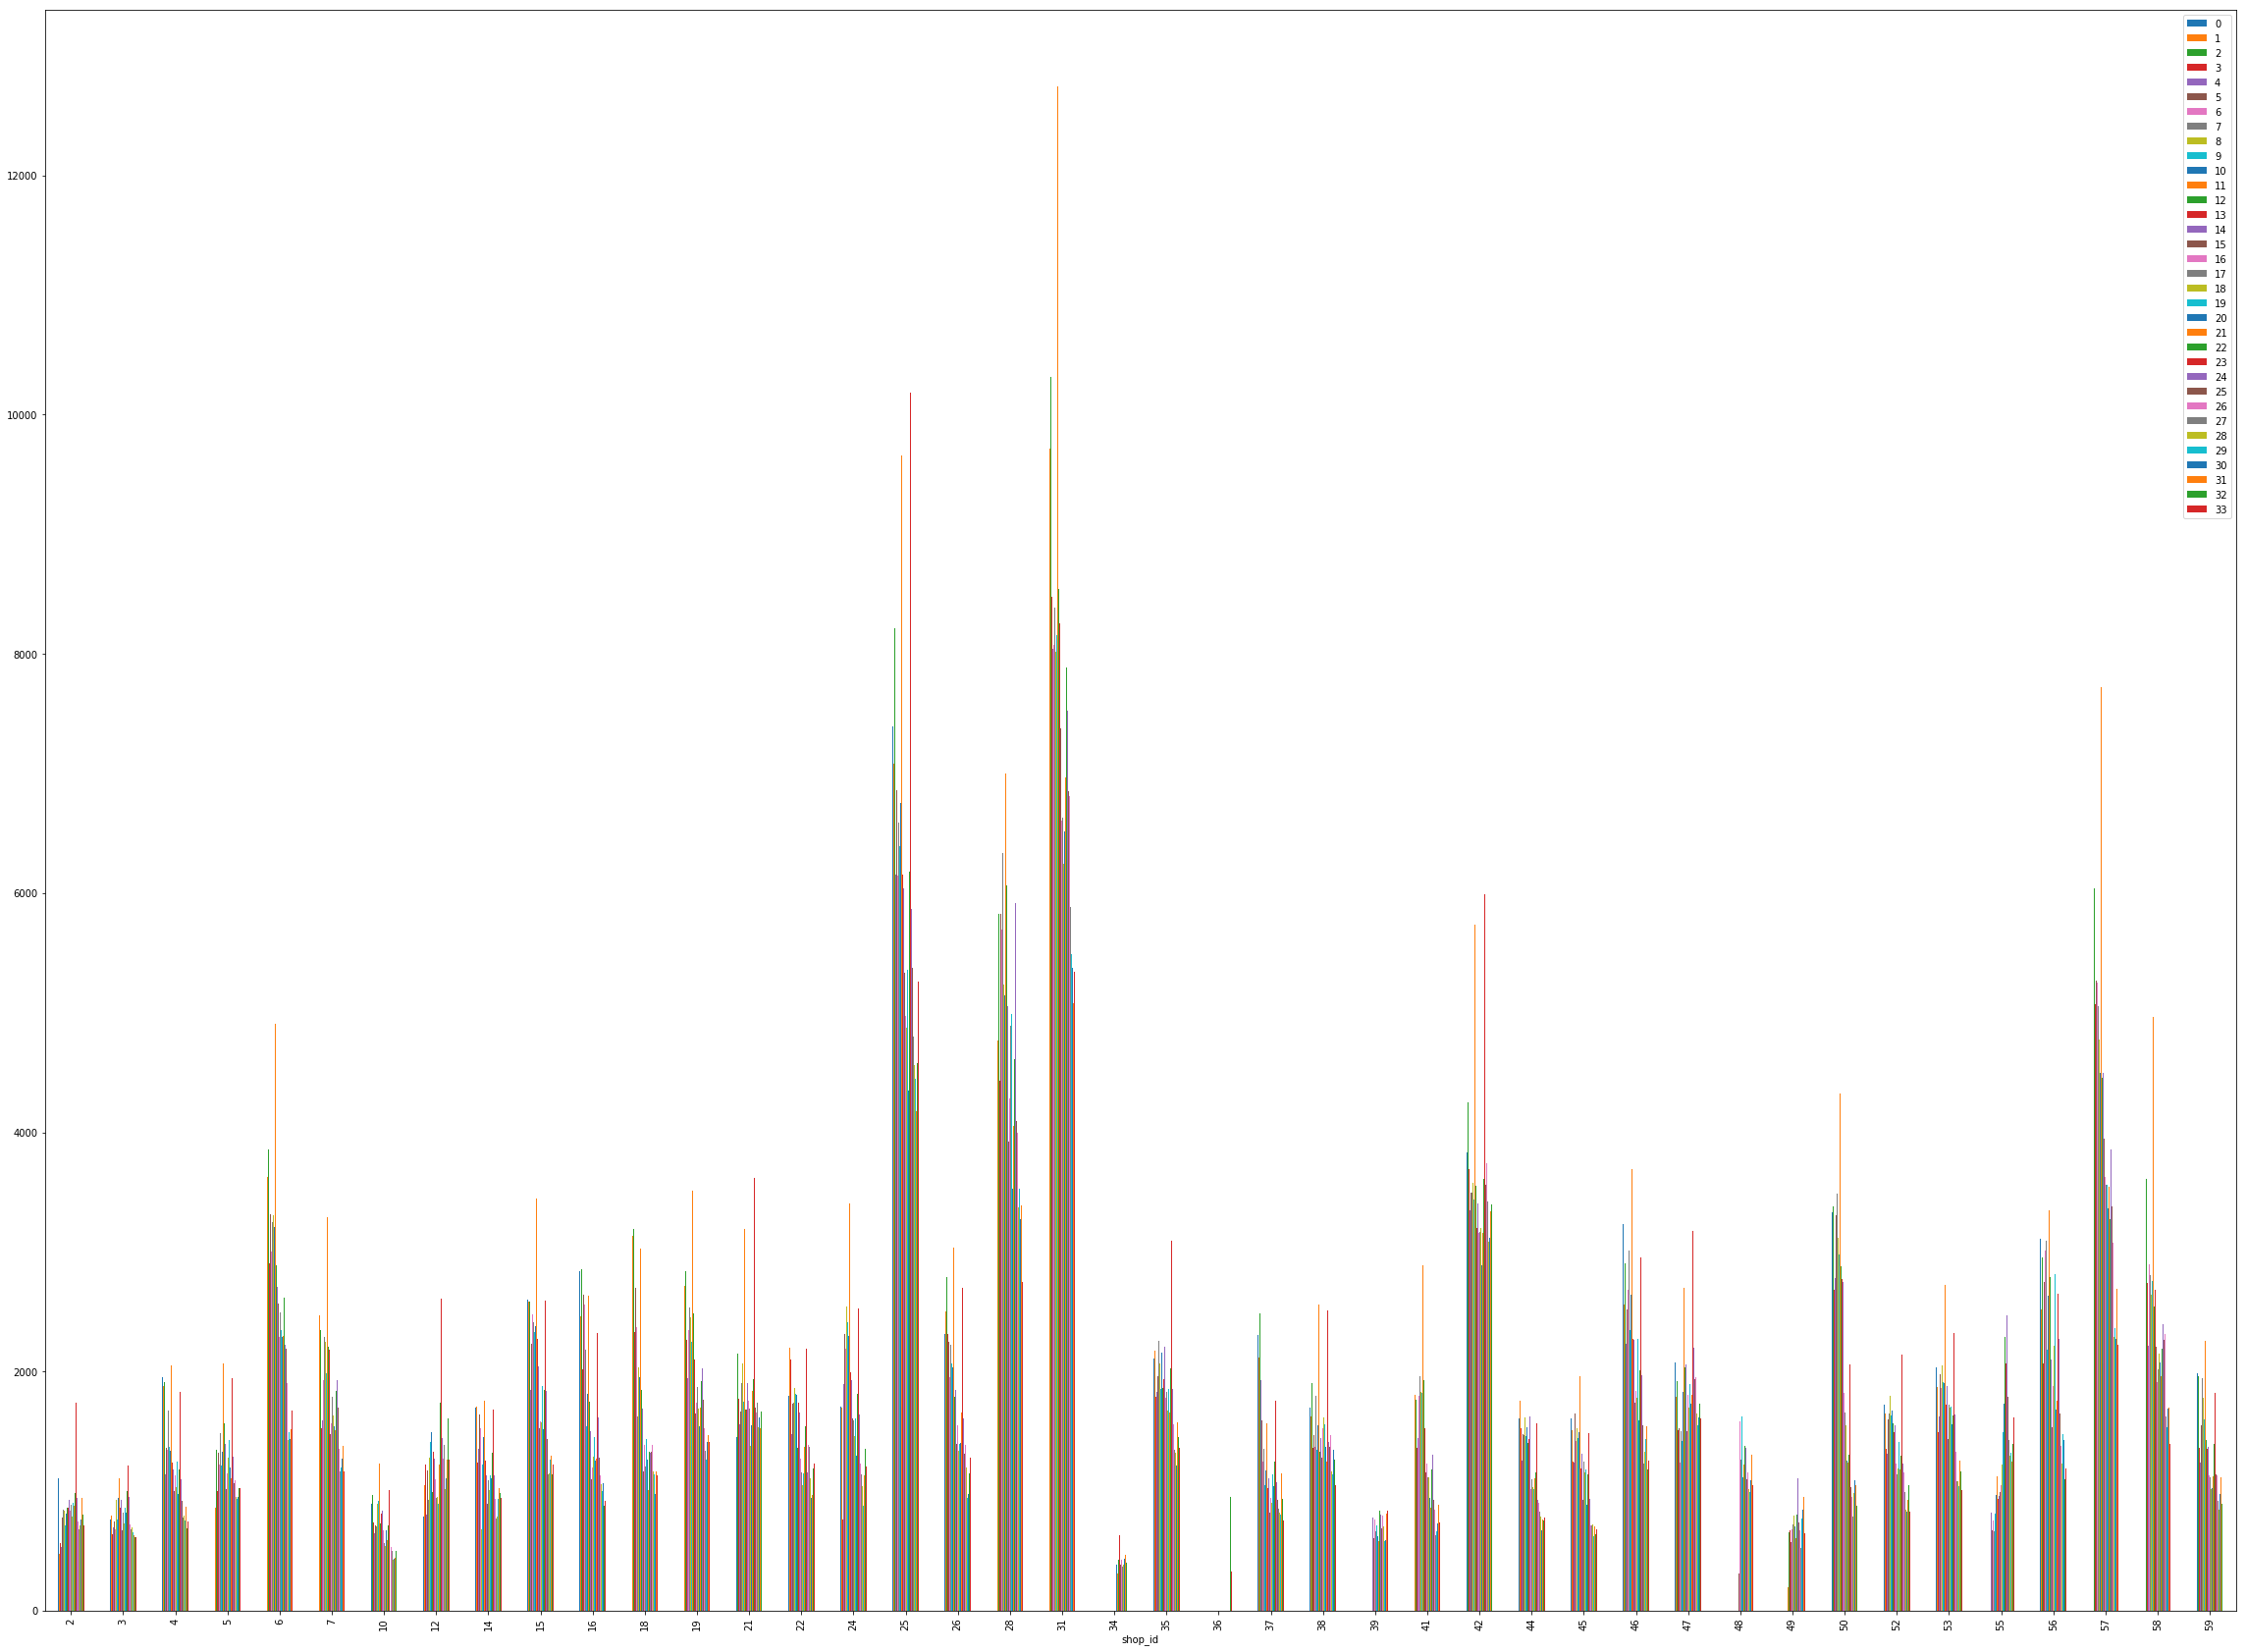

In [24]:
df_shop_months.plot.bar(figsize=(40, 30))

# Preprocess categories

In [25]:
df_cats = df_train_piv.iloc[:, :4]
df_cats.nunique()

shop_id                42
item_id             20813
item_category_id       62
bigcat                 16
dtype: int64

In [26]:
df_cats.loc[:, 'shop_item'] = df_cats['shop_id'].astype(str) + '_' + df_cats['item_id'].astype(str)
df_cats.loc[:, 'shop_category'] = df_cats['shop_id'].astype(str) + '_' + df_cats['item_category_id'].astype(str)
df_cats.loc[:, 'shop_bigcat'] = df_cats['shop_id'].astype(str) + '_' + df_cats['bigcat'].astype(str)
df_cats.head()

,shop_id,item_id,item_category_id,bigcat,shop_item,shop_category,shop_bigcat
0,2,27,19,5,2_27,2_19,2_5
1,2,30,40,7,2_30,2_40,2_7
2,2,31,37,7,2_31,2_37,2_7
3,2,32,40,7,2_32,2_40,2_7
4,2,33,37,7,2_33,2_37,2_7


In [27]:
from sklearn.preprocessing import OneHotEncoder
onehot_enc = OneHotEncoder()
# onehot_cols = df_cats.columns[df_cats.columns != 'item_id'].tolist()
onehot_cols = ['shop_id', 'item_category_id']
X_onehot = onehot_enc.fit_transform(df_cats.loc[:, onehot_cols])

In [28]:
label_cols = list(set(df_cats.columns.tolist()) - set(onehot_cols))
df_cats = df_cats.astype('category').astype(np.int32)
df_labels = df_cats[label_cols]
X_label = sparse.csr_matrix(df_labels.values)

In [29]:
def expanding_mean_encoding(df, group_cols, y_target):
    df.loc[:, '_y_target'] = y_target
    cumsum = df.groupby(group_cols)['_y_target'].cumsum() - df['_y_target']
    cumcnt = df.groupby(group_cols)['_y_target'].cumcount()
    return cumsum / cumcnt

In [30]:
def mean_encoding(df, group_cols, y_target):
    df.loc[:, '_y_target'] = y_target
    map_dict = df.groupby(group_cols)['_y_target'].mean().to_dict()
    return df[group_cols].map(map_dict).values

# Numeric features

In [31]:
def period_column_feats(X, period=12):
    '''
    get some periodic feature
    '''
    n_col = X.shape[1]
    feats = []

    for i in range(12):
        cols = [i]
        j = 1
        while i + j * period < n_col:
            cols.append(i + j * period)
            j += 1
        feats.extend([X[:, cols].mean(axis=1), X[:, cols].max(axis=1), X[:, cols].min(
            axis=1), X[:, cols].std(axis=1), np.median(X[:, cols], axis=1)])
    return np.column_stack(feats)


def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


def addtion_num_cols(X):
    return np.column_stack(
            (np.mean(X, axis=1),
             np.mean(X[:, -3:], axis=1), 
             np.mean(X[:, -6:], axis=1), 
             np.mean(X[:, -12:], axis=1),
             np.std(X, axis=1),
             np.std(X[:, -3:], axis=1), 
             np.std(X[:, -6:], axis=1), 
             np.std(X[:, -12:], axis=1),
#              np.apply_along_axis(running_mean, 1, X, N=3),
#              np.apply_along_axis(running_mean, 1, X, N=6),
            ))

In [32]:
def num_cols(X):
    X_diff = np.diff(X, axis=1)
    X_period = period_column_feats(X)
    
    X_ad = addtion_num_cols(X)
    X_diff_ad = addtion_num_cols(X_diff)
    X_period_ad = addtion_num_cols(X_period)
    
    return sparse.csr_matrix(np.column_stack((
        X,
        X_diff,
        X_period,
        X_ad,
        X_diff_ad,
        X_period_ad
    )))    

In [33]:
def predict_func(xm, bsts):
    preds = []
    for i, bst in enumerate(bsts):
        preds.append(bst.predict(xm, ntree_limit=df_limit.iloc[i, -1]))
#         print(df_limit.iloc[i, -1])
#         preds.append(bst.predict(xm))
    return np.mean(np.column_stack(preds), axis=1)

In [34]:
def apply_mean_encode(X, enc_cols, n=2, df_cats=df_cats):
    X_mean_code = np.empty((X.shape[0], len(enc_cols)*n))
#     X_mean_code_diff = np.empty((X.shape[0], len(enc_cols)*(n-1)))
    for i, enc_col in enumerate(enc_cols):
        for j in range(n):
            X_mean_code[:, i*n + j] = mean_encoding(df_cats, enc_col, X[:, -(j+1)])
#             if j > 0:
#                 X_mean_code_diff[:, i*(n-1) + (j-1)] = X_mean_code[:, i*n + j] - X_mean_code[:, i*n + j-1]          
#     return np.column_stack((X_mean_code, X_mean_code_diff))
    return X_mean_code

In [35]:
enc_cols = ['shop_id', 'shop_category', 'item_id', 'bigcat']
n_months = 22

# xgbost

In [36]:
if train_mode:
    # training_flag = True
    training_flag = False
    


    # enc_cols = ['shop_id']


    if training_flag:
        train_cols = [-12,  -1]
    #     train_cols = [-6, -5, -4, -3, -2, -1]
    else:
        train_cols = [-12,-2, -1]


    for train_col in train_cols:
        X_train = df_months.iloc[:, train_col - n_months:train_col].values
        y_train = df_months.iloc[:, train_col].values


    #     X_train = sparse.hstack((X_price, X_onehot, X_label, apply_mean_encode(X_train, enc_cols), num_cols(X_train)))

        X_train = sparse.hstack((X_onehot, X_label, apply_mean_encode(X_train, enc_cols), num_cols(X_train)))
    #     y_train = df_months.iloc[:, train_col].values - df_months.iloc[:, train_col-1].values

        if train_col == train_cols[0]:
            X_train_cum, y_train_cum = X_train, y_train
        else:
            X_train_cum = sparse.vstack((X_train_cum, X_train), format='csr')
            y_train_cum = np.concatenate((y_train_cum, y_train))

    print(X_train_cum.shape)
    gc.collect()

    if training_flag:
        val_col = train_cols[-1] + 1
    else:
        val_col = train_cols[-1]

    X_val = df_months.iloc[:, val_col - n_months:val_col].values
    y_val = df_months.iloc[:, val_col].values
    X_val = sparse.hstack((X_onehot, X_label, apply_mean_encode(X_val, enc_cols), num_cols(X_val)))
    # y_val = df_months.iloc[:, val_col].values - df_months.iloc[:, val_col-1].values

    last_col = -1
    X_last = df_months.iloc[:, last_col - n_months:last_col].values


    X_last = sparse.hstack((X_onehot, X_label, apply_mean_encode(X_last, enc_cols), num_cols(X_last)))
    y_last = df_months.iloc[:, last_col].values

    xgblast = xgb.DMatrix(X_last)

(1306281, 244)


In [37]:
bsts = []
df_limit = pd.DataFrame(columns=['i', 'limit'])
n_trees = 50

In [38]:
if train_mode:
    xgbval = xgb.DMatrix(X_val, y_val)
    tree_limit_choices = [40, 50, 60]

    last_rmses = []

    for i in range(n_trees):
#         if i < 30: continue
        
        np.random.seed(i+1)
        
        
        param = {'max_depth': np.random.choice([4, 5, 6]),
         'subsample': np.random.choice([0.6, 0.8, 1]),
         'colsample_bytree': np.random.choice([0.6, 0.8, 1]),
         #          'min_child_weight':0.5,
         'eta': 0.2,
         'seed': i + 1,
         'eval_metric': 'rmse'}
        
        
        idxes = np.random.choice(X_train_cum.shape[0], X_train_cum.shape[0])
        X_train_sample = X_train_cum[idxes]
        y_train_sample = y_train_cum[idxes]
        xgbtrain = xgb.DMatrix(X_train_sample, y_train_sample)
        bst = xgb.train(param, xgbtrain, num_boost_round=np.random.choice(tree_limit_choices))

#         xgbtrain = xgb.DMatrix(X_train_cum, y_train_cum)
#         watchlist = [(xgbtrain, 'train'), (xgbval, 'val')]
#         bst = xgb.train(param, xgbtrain, num_boost_round=40, evals=watchlist, early_stopping_rounds=10, verbose_eval=1)

        bsts.append(bst)
        bst.save_model('models/{}.model'.format(i))
        df_limit.loc[df_limit.shape[0]] = [i, bst.best_ntree_limit]
        df_limit.to_csv('models/df_limit.csv', index=False)

        preds_val = predict_func(xgbval, bsts)
        preds_last = predict_func(xgblast, bsts)
        print(i, bst.best_ntree_limit, np.sqrt(mean_squared_error(
            y_val, preds_val)), np.sqrt(mean_squared_error(y_last, preds_last)))
        last_rmses.append(np.sqrt(mean_squared_error(y_last, preds_last)))
        gc.collect()

    del xgbval
    gc.collect()

    preds_last = predict_func(xgblast, bsts)
    print(i, bst.best_ntree_limit, np.sqrt(mean_squared_error(
        y_val, preds_val)), np.sqrt(mean_squared_error(y_last, preds_last)))

0 50 0.551677098574 0.551677098574
1 60 0.558846962639 0.558846962639
2 40 0.553082317646 0.553082317646
3 60 0.538817246859 0.538817246859
4 50 0.532484444043 0.532484444043
5 50 0.532027409103 0.532027409103
6 40 0.538470776047 0.538470776047
7 50 0.542333378626 0.542333378626
8 50 0.540596121019 0.540596121019
9 40 0.542961201856 0.542961201856
10 60 0.542747008911 0.542747008911
11 50 0.540484348167 0.540484348167
12 60 0.538921808092 0.538921808092
13 40 0.541525807101 0.541525807101
14 50 0.543977267792 0.543977267792
15 40 0.544698806037 0.544698806037
16 60 0.544254578224 0.544254578224
17 60 0.542305985734 0.542305985734
18 50 0.541801099762 0.541801099762
19 50 0.540916341625 0.540916341625
20 60 0.541233559172 0.541233559172
21 40 0.542373564724 0.542373564724
22 60 0.541474734709 0.541474734709
23 50 0.539986990951 0.539986990951
24 50 0.541498136503 0.541498136503
25 40 0.542251417957 0.542251417957
26 50 0.543634986294 0.543634986294
27 40 0.544006108577 0.544006108577
28

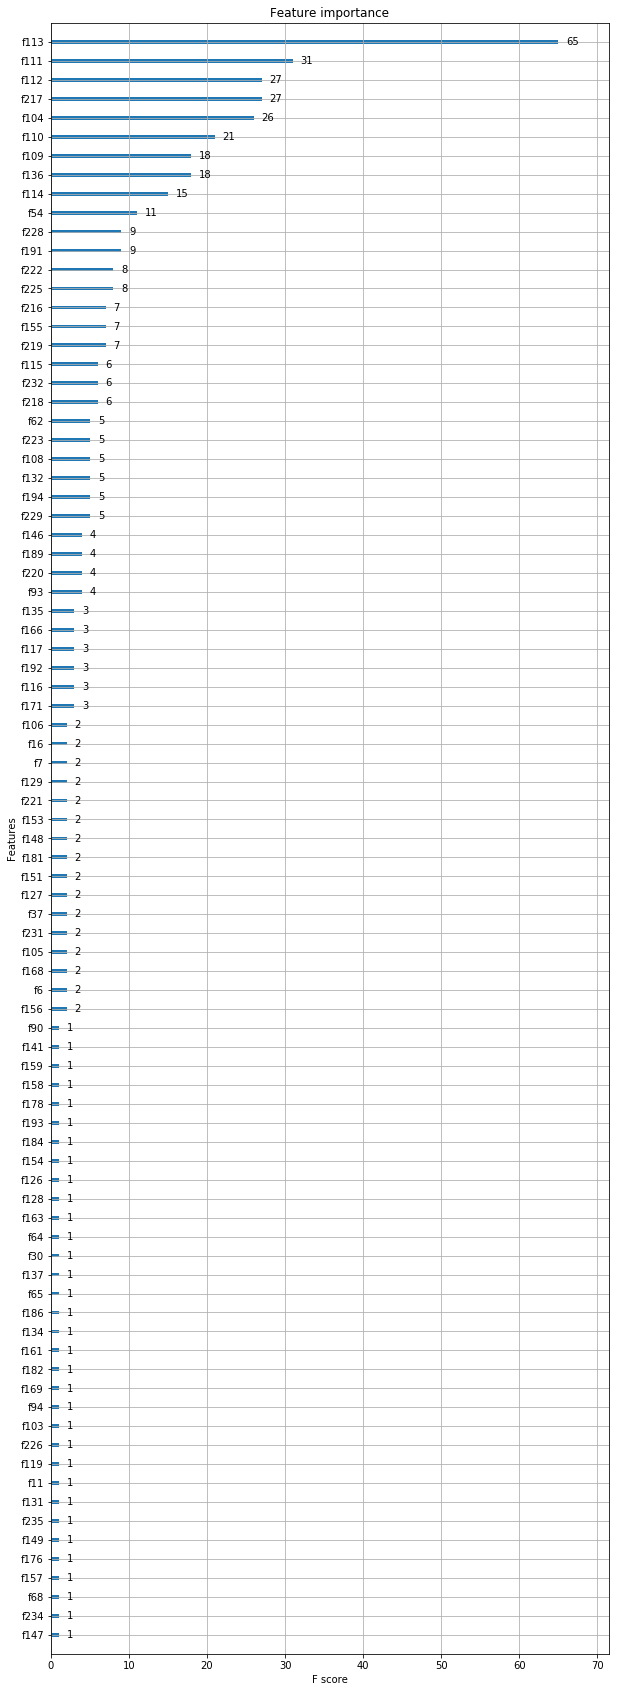

In [47]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

my_plot_importance(bst, figsize=(10, 30))

# test

In [39]:
import os

df_limit = pd.read_csv('models/df_limit.csv')

bsts = []
for i in os.listdir('models'):
    if 'model' in i:
        bsts.append(xgb.Booster(model_file='models/{}'.format(i)))

In [40]:
df_test = df_test.merge(df_train_piv[df_train_piv.columns[~df_train_piv.columns.isin(['item_category_id', 'bigcat'])]], how = "left", on = ["shop_id", "item_id"])
df_test[['bigcat']] = number.fit_transform(df_test.bigcat)
df_test.iloc[:, -34:] = df_test.iloc[:, -34:].fillna(0)

df_test_cats = df_test[['ID', 'shop_id', 'item_id']].merge(df_cats, how='left', on=['shop_id', 'item_id'])
df_test_cats.head()

X_test_label = sparse.csr_matrix(df_test_cats[label_cols].values)

X_test_onehot = onehot_enc.transform(df_test_cats.loc[:, onehot_cols])
X_test = df_test.iloc[:, -n_months:].values

X_test = sparse.hstack((X_test_onehot, X_test_label, apply_mean_encode(X_test, enc_cols, df_cats=df_test_cats), num_cols(X_test)))

xgbtest = xgb.DMatrix(X_test)

In [41]:
preds = predict_func(xgbtest, bsts)
preds = np.clip(preds, 0, 20)

print(np.mean(preds))
np.std(preds)

0.299389


0.80699366

In [42]:
# Normalize prediction to [0-20]
# sub_df = pd.DataFrame({'ID':df_test.ID,'item_cnt_month': preds-(np.mean(preds) - 0.285)})
sub_df = pd.DataFrame({'ID':df_test.ID,'item_cnt_month': preds-(np.mean(preds) - 0.285)})

from datetime import datetime
sub_df.loc[df_test['item_id'] == 20949, 'item_cnt_month']= 20

sub_df.to_csv('submission/xgboost_{}.csv'.format(datetime.now().strftime('%Y-%m-%d %H-%M-%S')),index=False)

sub_df.head()

,ID,item_cnt_month
0,0,0.684283
1,1,0.030477
2,2,0.933613
3,3,0.393307
4,4,0.811223


# try to find leakage

In [43]:
df_leakege = df_test.iloc[:, :5]
df_leakege.loc[:, 'pred'] = preds
df_leakege

,ID,shop_id,item_id,item_category_id,bigcat,pred
0,0,5,5037,19,5,0.682216
1,1,5,5320,55,8,0.047845
2,2,5,5233,19,5,0.964948
3,3,5,5232,23,5,0.408904
4,4,5,5268,20,5,0.931854
5,5,5,5039,23,5,0.600858
6,6,5,5041,20,5,0.935952
7,7,5,5046,55,8,0.163827
8,8,5,5319,55,8,1.105652
9,9,5,5003,20,5,1.500616


In [44]:
# df_leakege.to_csv('df_leakege.csv', index=False)

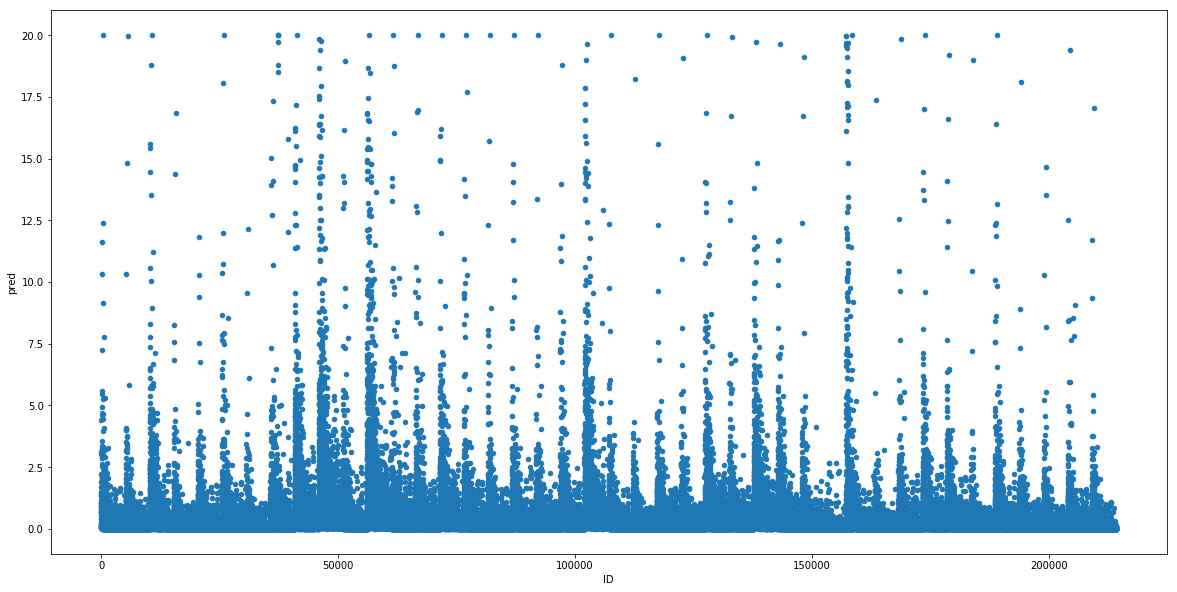

In [45]:
df_leakege.plot.scatter('ID', 'pred', figsize=(20, 10))

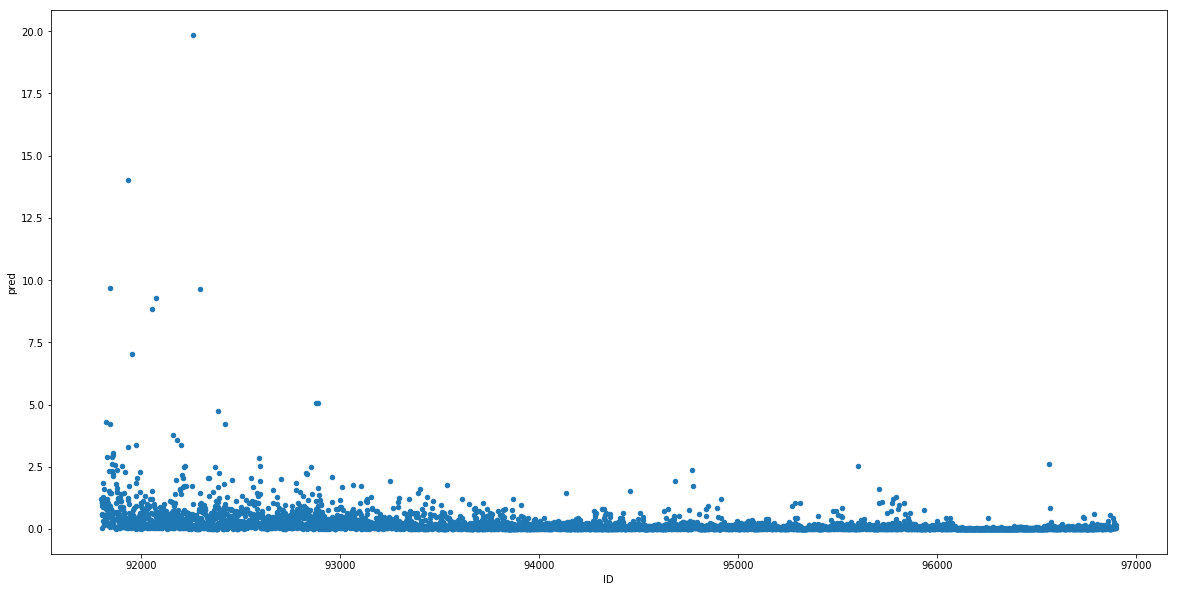

In [109]:
df_leakege[df_leakege['shop_id'] == 14].plot.scatter('ID', 'pred', figsize=(20, 10))

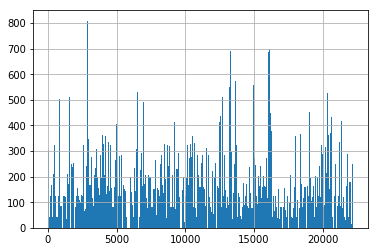

In [94]:
df_leakege.loc[df_leakege['pred'] < 0.5, 'item_id'].hist(bins=1000)

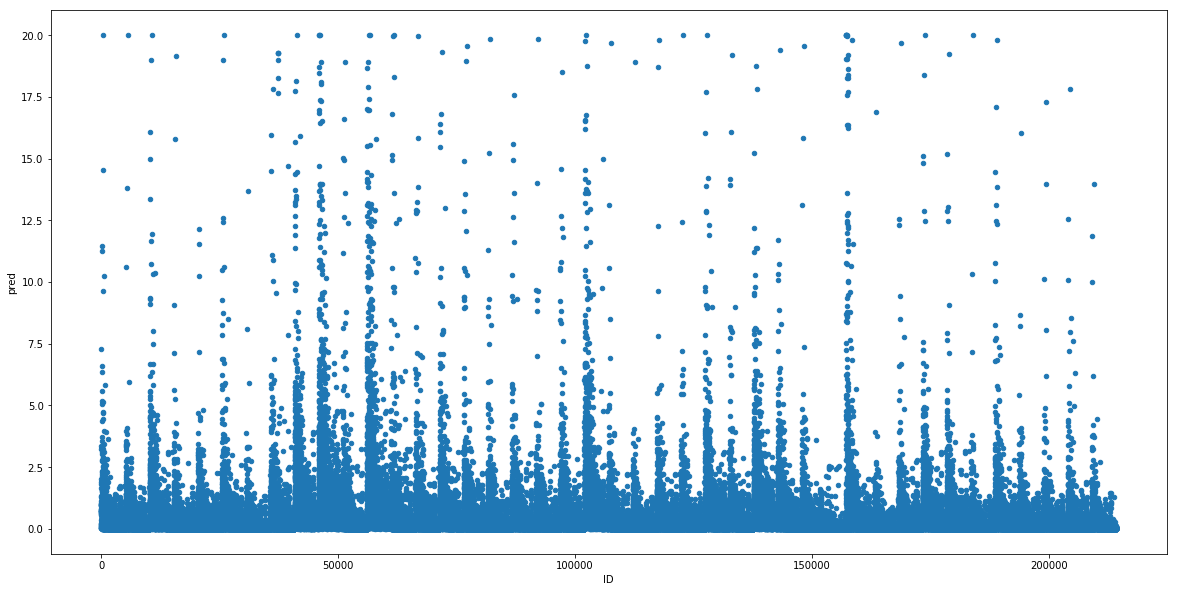

In [96]:
col = 'shop_id'
df_leakege.sort_values(col).plot.scatter(col, 'pred', figsize=(20, 10))

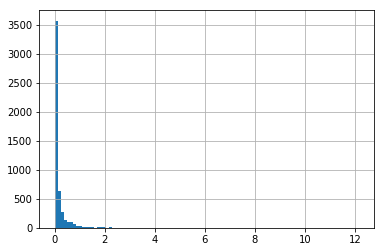

In [74]:
df_leakege[df_leakege['shop_id'] == 2]['pred'].hist(bins=100)

/Users/liew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


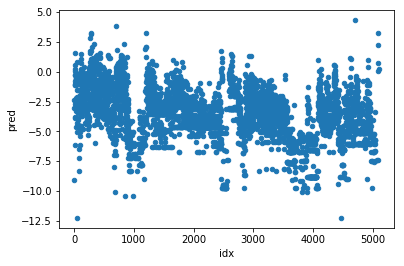

In [115]:
df_tmp = df_leakege[df_leakege['shop_id'] == 14]
df_tmp = df_tmp.sort_values(['shop_id', 'item_category_id'])
df_tmp.loc[:, 'idx'] = range(len(df_tmp))
df_tmp.loc[:, 'pred'] = np.log2(df_tmp.loc[:, 'pred'])
df_tmp.plot.scatter('idx', 'pred')

In [110]:
df_sub = pd.read_csv('submission/xgboost_2018-07-29 23-42-20.csv')
df_sub.loc[df_leakege['item_id'] == 20949, 'item_cnt_month'] = 20
df_sub.head()

,ID,item_cnt_month
0,0,0.679175
1,1,0.000000
2,2,0.914315
3,3,0.387050
4,4,0.892038


In [111]:
df_sub.to_csv('submission/xgboost_{}.csv'.format(datetime.now().strftime('%Y-%m-%d %H-%M-%S')),index=False)